In [18]:
# from getopt import getopt
# import cloudpickle
# import pickle
# import sys
# import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli, betabinom
from scipy.stats import linregress
# from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
import jax
from pymc.sampling_jax import sample_numpyro_nuts
# from time import time, sleep
# from datetime import timedelta

## Checking pval

In [19]:
oa0_test_results = (pd.read_csv("data/simulations/oa0_test.csv")
                    .sort_values("sim_id")
                    .reset_index()
                    .drop(columns="index"))
oa1_test_results = (pd.read_csv("data/simulations/oa1_test.csv")
                    .sort_values("sim_id")
                    .reset_index()
                    .drop(columns="index"))

In [20]:
print("Checking if all values for the following columns match\n")
for c in ["p_diff", "n_raters", "scores_per_r", "total_scores", "seed"]:
    print(c, all(oa0_test_results[c]==oa1_test_results[c]))

Checking if all values for the following columns match

p_diff True
n_raters True
scores_per_r True
total_scores True
seed True


In [30]:
a=oa0_test_results
b=oa1_test_results.rename(columns={"propz_pval":"propz_pvalOA", "bht_pval":"bht_pvalOA"})
c=pd.merge(a,b[["sim_id", "propz_pvalOA", "bht_pvalOA"]],on="sim_id")
c = c[["sim_id", "trial_id", "p_diff", "n_raters", "scores_per_r", "total_scores", 
       "seed", "propz_pval", "propz_pvalOA", "bht_pval", "bht_pvalOA"]]
c["propz_OA_factor"]=np.log10(c["propz_pvalOA"]/c["propz_pval"])
c["propz_OA_factor"] = c["propz_OA_factor"].round(4)
c["bht_pval"] += 1e-3
c["bht_pvalOA"] += 1e-3
c["bht_OA_factor"]=np.log10(c["bht_pvalOA"]/c["bht_pval"])



In [31]:
c["bht_OA_factor"].sum()

-3.22568070342393

In [32]:
var = "bht_OA_factor"
c.sort_values(var)[:20]

,sim_id,trial_id,p_diff,n_raters,scores_per_r,total_scores,seed,propz_pval,propz_pvalOA,bht_pval,bht_pvalOA,propz_OA_factor,bht_OA_factor
26,26,0,0.055,103,35,3605,68,0.039920,1.399330e-02,0.014,0.001,-0.4553,-1.146128
45,45,0,0.055,127,35,4445,87,0.027371,7.836827e-06,0.012,0.001,-3.5432,-1.079181
16,16,0,0.055,84,35,2940,58,0.054903,9.683655e-07,0.012,0.001,-4.7536,-1.079181
49,49,0,0.055,64,35,2240,91,0.017702,4.242893e-03,0.011,0.001,-0.6204,-1.041393
2,2,0,0.055,22,35,770,44,0.584345,1.443134e-01,0.548,0.052,-0.6074,-1.022777
20,20,0,0.055,107,35,3745,62,0.010198,6.183778e-05,0.009,0.001,-2.2173,-0.954243
9,9,0,0.055,23,35,805,51,0.399285,1.996174e-01,0.323,0.038,-0.3011,-0.929419
25,25,0,0.055,143,35,5005,67,0.017018,1.731246e-03,0.012,0.002,-0.9926,-0.778151
13,13,0,0.055,30,35,1050,55,0.021328,1.676054e-03,0.011,0.002,-1.1047,-0.740363
10,10,0,0.055,105,35,3675,52,0.025044,2.604507e-03,0.010,0.002,-0.9830,-0.698970


In [33]:
c.sort_values(var)[-20:]

,sim_id,trial_id,p_diff,n_raters,scores_per_r,total_scores,seed,propz_pval,propz_pvalOA,bht_pval,bht_pvalOA,propz_OA_factor,bht_OA_factor
32,32,0,0.055,137,35,4795,74,4.414724e-07,5.248321e-06,0.001,0.001,1.0751,0.000000
28,28,0,0.055,93,35,3255,70,6.141846e-05,1.114203e-05,0.001,0.001,-0.7413,0.000000
12,12,0,0.055,119,35,4165,54,1.902978e-02,1.079796e-07,0.001,0.001,-5.2461,0.000000
11,11,0,0.055,125,35,4375,53,2.739521e-03,1.730796e-02,0.005,0.007,0.8006,0.146128
30,30,0,0.055,30,35,1050,72,4.117688e-02,3.350035e-02,0.015,0.021,-0.0896,0.146128
7,7,0,0.055,49,35,1715,49,1.030801e-02,1.167367e-01,0.004,0.008,1.0540,0.301030
6,6,0,0.055,79,35,2765,48,4.701024e-02,2.392645e-01,0.043,0.086,0.7067,0.301030
3,3,0,0.055,77,35,2695,45,6.143874e-04,3.238905e-03,0.001,0.002,0.7220,0.301030
34,34,0,0.055,23,35,805,76,2.787763e-04,2.270933e-03,0.001,0.002,0.9109,0.301030
56,56,0,0.055,68,35,2380,98,5.315673e-06,3.440632e-02,0.001,0.002,3.8111,0.301030


## Checking scores

In [59]:
def postrr_var(n_success, total):
    a = n_success+1
    b = total-n_success+1
    return a*b/((a+b+1)*(a+b)**2)

def postrr_p(n_success, total):
    a = n_success+1
    b = total-n_success+1
    return betabinom.pmf(
        n=1,
        k=1,
        a=a,
        b=b
    )

In [60]:
sim_id = 59
test = pd.read_csv(f"data/oa0_test/score_{sim_id}.csv")
testOA = pd.read_csv(f"data/oa1_test/score_{sim_id}.csv")

In [64]:
# Checking expected variance reduction
scores=test
s = (scores.groupby("sim_topic_id").agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (scores.groupby("sim_topic_id").agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topic_var = pd.merge(s, c, on="sim_topic_id")
topic_var["variance"]=postrr_var(topic_var["sum"], topic_var["count"])
topic_var["p"] = postrr_p(topic_var["sum"], topic_var["count"])
topic_var["var0"] = postrr_var(topic_var["sum"], topic_var["count"]+1)
topic_var["var1"] = postrr_var(topic_var["sum"]+1, topic_var["count"]+1)
topic_var["expected_var"] = topic_var["p"]*topic_var["var1"]+(1-topic_var["p"])*topic_var["var0"]
topic_var["var_reduction"] = topic_var["expected_var"]-topic_var["variance"]
topic_var.sort_values("var_reduction")

,sim_topic_id,sum,count,variance,p,var0,var1,expected_var,var_reduction
56,56,17,34,0.006757,0.500000,0.006574,0.006574,0.006574,-0.000183
4,4,18,34,0.006736,0.527778,0.006574,0.006536,0.006554,-0.000182
13,13,15,34,0.006673,0.444444,0.006459,0.006536,0.006493,-0.000180
89,89,19,34,0.006673,0.555556,0.006536,0.006459,0.006493,-0.000180
7,7,19,34,0.006673,0.555556,0.006536,0.006459,0.006493,-0.000180
...,...,...,...,...,...,...,...,...,...
36,36,35,35,0.000692,0.972973,0.001278,0.000657,0.000674,-0.000018
92,92,35,35,0.000692,0.972973,0.001278,0.000657,0.000674,-0.000018
77,77,35,35,0.000692,0.972973,0.001278,0.000657,0.000674,-0.000018
1,1,35,35,0.000692,0.972973,0.001278,0.000657,0.000674,-0.000018


In [65]:
# Checking expected variance reduction
scores=testOA
s = (scores.groupby("sim_topic_id").agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (scores.groupby("sim_topic_id").agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topic_var = pd.merge(s, c, on="sim_topic_id")
topic_var["variance"]=postrr_var(topic_var["sum"], topic_var["count"])
topic_var["p"] = postrr_p(topic_var["sum"], topic_var["count"])
topic_var["var0"] = postrr_var(topic_var["sum"], topic_var["count"]+1)
topic_var["var1"] = postrr_var(topic_var["sum"]+1, topic_var["count"]+1)
topic_var["expected_var"] = topic_var["p"]*topic_var["var1"]+(1-topic_var["p"])*topic_var["var0"]
topic_var["var_reduction"] = topic_var["expected_var"]-topic_var["variance"]
topic_var.sort_values("var_reduction")

,sim_topic_id,sum,count,variance,p,var0,var1,expected_var,var_reduction
44,44,19,20,0.003593,0.909091,0.004726,0.003308,0.003437,-0.000156
65,65,19,20,0.003593,0.909091,0.004726,0.003308,0.003437,-0.000156
9,9,19,20,0.003593,0.909091,0.004726,0.003308,0.003437,-0.000156
83,83,13,40,0.005168,0.333333,0.004990,0.005162,0.005048,-0.000120
19,19,9,37,0.004767,0.256410,0.004573,0.004863,0.004647,-0.000119
...,...,...,...,...,...,...,...,...,...
15,15,18,18,0.002262,0.950000,0.003917,0.002061,0.002154,-0.000108
17,17,18,18,0.002262,0.950000,0.003917,0.002061,0.002154,-0.000108
77,77,18,18,0.002262,0.950000,0.003917,0.002061,0.002154,-0.000108
42,42,18,18,0.002262,0.950000,0.003917,0.002061,0.002154,-0.000108


## Inference

In [40]:
# Subtracting 50 from cordel 1 topic_ids to fix phantom topic_id problem
test.loc[test["sim_cordel_id"]==1, "sim_topic_id"]-=50
testOA.loc[testOA["sim_cordel_id"]==1, "sim_topic_id"]-=50

In [41]:
n_chains = 2
seed = 41+sim_id
# seed = 21

SAMPLE_JAX = True
chain_method = "vectorized"

In [42]:
sample = test
glm_test = {"model":pm.Model()}
glm = glm_test

In [43]:
# sample = scores[scores["trial_id"]==0]
if seed != None:
    np.random.seed(seed)

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
corpus_array = np.array([0]*len(sample))
n_corpora = 1

model_array = np.array(sample["sim_cordel_id"])
n_models = sample["sim_cordel_id"].nunique()

cordel_array = np.array(sample["sim_cordel_id"])
n_cordels = sample["sim_cordel_id"].nunique()

topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
n_topics = sample["sim_topic_id"].nunique()

rater_array = np.array(sample["sim_rater_id"])
n_raters = sample["sim_rater_id"].nunique()

score_array = np.array(sample["intrusion"])

# Model and MCMC specifications
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

# Rater, Topic, Cordel model

glm["model"] = pm.Model()
with glm["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")
    
    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    c_diff = pm.Deterministic("c_diff", c_mean[1]- c_mean[0])
#     c_mean = pm.Deterministic("c_mean", 
#                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
#                               dims="obs_id")
#     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

    if SAMPLE_JAX:
        glm["trace"]=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
    else:
        glm["trace"]=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

# n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()

#     return  n_negatives/len(sample)

/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:01.440785
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:35<00:00, 56.41it/s]


Sampling time =  0:00:39.358586
Transforming variables...
Transformation time =  0:00:00.624743
Computing Log Likelihood...
Log Likelihood time =  0:00:01.631030


In [44]:
# Repeate code below again for OA settings
sample = testOA
glm_testOA = {"model":pm.Model()}
glm = glm_testOA

In [45]:
# sample = scores[scores["trial_id"]==0]
if seed != None:
    np.random.seed(seed)

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
corpus_array = np.array([0]*len(sample))
n_corpora = 1

model_array = np.array(sample["sim_cordel_id"])
n_models = sample["sim_cordel_id"].nunique()

cordel_array = np.array(sample["sim_cordel_id"])
n_cordels = sample["sim_cordel_id"].nunique()

topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
n_topics = sample["sim_topic_id"].nunique()

rater_array = np.array(sample["sim_rater_id"])
n_raters = sample["sim_rater_id"].nunique()

score_array = np.array(sample["intrusion"])

# Model and MCMC specifications
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

# Rater, Topic, Cordel model

glm["model"] = pm.Model()
with glm["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")
    
    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    c_diff = pm.Deterministic("c_diff", c_mean[1]- c_mean[0])
#     c_mean = pm.Deterministic("c_mean", 
#                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
#                               dims="obs_id")
#     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

    if SAMPLE_JAX:
        glm["trace"]=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
    else:
        glm["trace"]=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

# n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()

#     return  n_negatives/len(sample)

Compiling...
Compilation time =  0:00:01.334037
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:38<00:00, 52.53it/s]


Sampling time =  0:00:38.355681
Transforming variables...
Transformation time =  0:00:00.073907
Computing Log Likelihood...
Log Likelihood time =  0:00:01.065175


In [46]:
n_neg_test = (glm_test["trace"].posterior["c_diff"]<0).sum().item()
n_neg_testOA = (glm_testOA["trace"].posterior["c_diff"]<0).sum().item()
total = glm_test["trace"].posterior["c_diff"].count().item()
pval_test = n_neg_test/total
pval_testOA = n_neg_testOA/total
print(f"pval test: {pval_test}, pval testOA: {pval_testOA}")

pval test: 0.0, pval testOA: 0.041


In [47]:
glm_test["summary_stat"] = create_summary_stat(glm_test["trace"])
glm_testOA["summary_stat"] = create_summary_stat(glm_testOA["trace"])

# Deleting diagnostic columns
diag_cols = ['mcse_mean', 'mcse_sd', 'ess_bulk', 'ess_tail', 'r_hat']
glm_test["summary_stat"] = glm_test["summary_stat"].drop(columns=diag_cols)
glm_testOA["summary_stat"] = glm_testOA["summary_stat"].drop(columns=diag_cols)

# Creating Summary Stats
a = glm_test["summary_stat"]
b = glm_testOA["summary_stat"].rename(columns={c:c+"OA" for c in glm_testOA["summary_stat"].columns})
c = (pd.merge(a,b, left_on=["param", "param_num"], right_on=["paramOA", "param_numOA"])
       .drop(columns=["paramOA", "param_numOA"]))

In [48]:
c[c["param"].isin(["c_mean", "c_diff"])]

,param,param_num,mean,sd,hdi_3%,hdi_97%,meanOA,sdOA,hdi_3%OA,hdi_97%OA
203,c_mean,0,0.6712,0.0143,0.6461,0.7007,0.6861,0.0124,0.6611,0.7082
204,c_mean,1,0.7201,0.0122,0.6964,0.7428,0.7103,0.0125,0.6872,0.7338
205,c_diff,NaN,0.0489,0.0141,0.0226,0.0754,0.0241,0.0138,-0.0015,0.0497


In [49]:
# Plotting total variance of uniform vs OA topic effects
mu0 = c[(c["param"]=="mu")&(c["param_num"]=="0")]["mean"].item()
mu1 = c[(c["param"]=="mu")&(c["param_num"]=="1")]["mean"].item()
mu0OA = c[(c["param"]=="mu")&(c["param_num"]=="0")]["meanOA"].item()
mu1OA = c[(c["param"]=="mu")&(c["param_num"]=="1")]["meanOA"].item()

sigma_a = c[c["param"]=="sigma_a"]["mean"].item()
sigma_aOA = c[c["param"]=="sigma_a"]["meanOA"].item()

In [50]:
c

,param,param_num,mean,sd,hdi_3%,hdi_97%,meanOA,sdOA,hdi_3%OA,hdi_97%OA
0,zr,0,1.0603,0.6227,-0.0926,2.2376,0.2101,0.6661,-1.0046,1.5283
1,zr,1,1.0346,0.6095,-0.0088,2.2586,1.1141,0.6766,-0.1969,2.3347
2,zr,2,0.4881,0.6323,-0.6134,1.8153,0.3710,0.6613,-1.0014,1.5085
3,zr,3,0.6131,0.6110,-0.5923,1.6441,0.8320,0.6758,-0.4043,2.0770
4,zr,4,0.6767,0.6219,-0.5547,1.7715,1.0802,0.6877,-0.3024,2.2785
...,...,...,...,...,...,...,...,...,...,...
201,sigma_r,NaN,0.5753,0.0679,0.4507,0.6999,0.4969,0.0625,0.3832,0.6172
202,sigma_a,NaN,1.2997,0.1147,1.0681,1.5019,1.2653,0.1219,1.0386,1.4926
203,c_mean,0,0.6712,0.0143,0.6461,0.7007,0.6861,0.0124,0.6611,0.7082
204,c_mean,1,0.7201,0.0122,0.6964,0.7428,0.7103,0.0125,0.6872,0.7338


In [51]:
za = c[c["param"]=="za"]
za[["sim_cordel_id", "sim_topic_id"]] = za["param_num"].str.split(",", expand=True)
za["sim_cordel_id"] = za["sim_cordel_id"].str.strip().astype(int)
za["sim_topic_id"] = za["sim_topic_id"].str.strip().astype(int)

za.loc[za["sim_cordel_id"]==0,"topic_eff_spread"] = expit(mu0 + za["hdi_97%"]*sigma_a)-expit(mu0 + za["hdi_3%"]*sigma_a)
za.loc[za["sim_cordel_id"]==1,"topic_eff_spread"] = expit(mu1 + za["hdi_97%"]*sigma_a)-expit(mu1 + za["hdi_3%"]*sigma_a)
za.loc[za["sim_cordel_id"]==0,"topic_eff_spreadOA"] = expit(mu0OA + za["hdi_97%OA"]*sigma_a)-expit(mu0OA + za["hdi_3%OA"]*sigma_a)
za.loc[za["sim_cordel_id"]==1,"topic_eff_spreadOA"] = expit(mu1OA + za["hdi_97%OA"]*sigma_a)-expit(mu1OA + za["hdi_3%OA"]*sigma_a)

/tmp/ipykernel_6984/938748179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za[["sim_cordel_id", "sim_topic_id"]] = za["param_num"].str.split(",", expand=True)
/tmp/ipykernel_6984/938748179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za[["sim_cordel_id", "sim_topic_id"]] = za["param_num"].str.split(",", expand=True)
/tmp/ipykernel_6984/938748179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

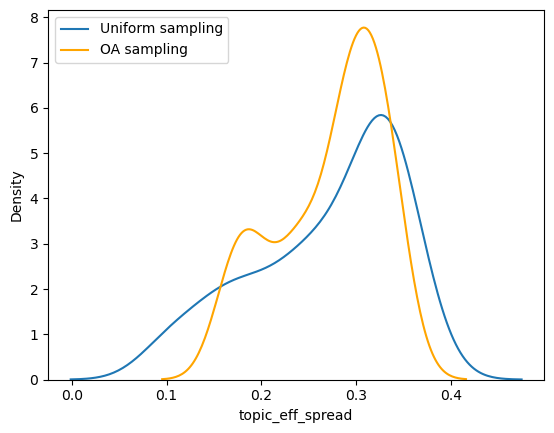

In [52]:
sns.kdeplot(za["topic_eff_spread"], label="Uniform sampling")
sns.kdeplot(za["topic_eff_spreadOA"], color="orange", label="OA sampling")
plt.legend()
plt.show()

In [53]:
# Joining posterior summary stats with scores

s = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sumOA"}).reset_index())
c = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"countOA"}).reset_index())
topicsOA = pd.merge(s, c, on=["sim_cordel_id", "sim_topic_id"])
topicsOA["pOA"] = topicsOA["sumOA"]/topicsOA["countOA"]

In [54]:
s = (test.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (test.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topics = pd.merge(s, c, on=["sim_cordel_id", "sim_topic_id"])
topics["p"] = topics["sum"]/topics["count"]

In [55]:
za = za.drop(columns=[c for c in a.columns if c[:3] in ("par", "hdi")])
a = pd.merge(za, topicsOA, on=["sim_cordel_id", "sim_topic_id"], how="left")
a = pd.merge(a, topics, on=["sim_cordel_id", "sim_topic_id"], how="left")

In [56]:
a["spread_improv"] = a["topic_eff_spreadOA"] - a["topic_eff_spread"]

In [57]:
# The issue is that log odds variance is greatest closest to 0 and 1!!
# To perform the comparison, we need to compare the probability, not log odds.
print("topic_eff_spread measures the difference between 3%hdi and 97%hdi of expit(topic effect)")
var = "spread_improv"
a.sort_values(var)[:10]

topic_eff_spread measures the difference between 3%hdi and 97%hdi of expit(topic effect)


,mean,sd,meanOA,sdOA,hdi_3%OA,hdi_97%OA,sim_cordel_id,sim_topic_id,topic_eff_spread,topic_eff_spreadOA,sumOA,countOA,pOA,sum,count,p,spread_improv
12,0.6447,0.3966,1.2701,0.5564,0.2749,2.3251,0,12,0.257287,0.184185,22,23,0.956522,30,35,0.857143,-0.073102
31,0.0480,0.3130,0.6335,0.3939,-0.0819,1.3704,0,31,0.297092,0.229009,27,32,0.843750,25,35,0.714286,-0.068083
62,-0.4618,0.3077,0.0771,0.3378,-0.5575,0.6898,1,12,0.332899,0.279467,28,37,0.756757,22,35,0.628571,-0.053432
47,-0.3603,0.3086,0.0674,0.3243,-0.5324,0.6822,0,47,0.339755,0.289361,28,38,0.736842,20,34,0.588235,-0.050394
8,-0.2533,0.3023,0.0412,0.3134,-0.5009,0.6877,0,8,0.328499,0.280233,28,39,0.717949,22,35,0.628571,-0.048266
28,-0.4459,0.2984,-0.1717,0.2873,-0.6821,0.3899,0,28,0.336259,0.288212,27,41,0.658537,19,34,0.558824,-0.048047
11,-0.1040,0.3204,0.1879,0.3455,-0.4368,0.8473,0,11,0.329259,0.281766,28,37,0.756757,23,34,0.676471,-0.047492
37,-0.4032,0.2979,-0.0101,0.3065,-0.5935,0.5416,0,37,0.331822,0.286794,28,40,0.700000,19,34,0.558824,-0.045028
74,0.4195,0.3671,1.3629,0.6164,0.2378,2.5067,1,24,0.219737,0.175197,18,18,1.000000,29,34,0.852941,-0.044540
72,-0.5943,0.3211,-0.3037,0.3094,-0.8358,0.3190,1,22,0.351608,0.310041,27,41,0.658537,21,34,0.617647,-0.041567


In [58]:
a.sort_values(var)[-10:]

,mean,sd,meanOA,sdOA,hdi_3%OA,hdi_97%OA,sim_cordel_id,sim_topic_id,topic_eff_spread,topic_eff_spreadOA,sumOA,countOA,pOA,sum,count,p,spread_improv
68,0.4430,0.3875,0.1320,0.3521,-0.5373,0.8092,1,18,0.229319,0.287916,28,36,0.777778,30,35,0.857143,0.058597
94,0.7254,0.4200,0.1810,0.3509,-0.4737,0.8384,1,44,0.206683,0.271832,28,36,0.777778,30,34,0.882353,0.065148
92,1.7222,0.6205,1.4647,0.6555,0.2829,2.7307,1,42,0.102914,0.169428,18,18,1.000000,35,35,1.000000,0.066514
36,1.9272,0.5784,1.4976,0.6420,0.3575,2.6880,0,36,0.107091,0.173887,18,18,1.000000,35,35,1.000000,0.066796
1,2.0210,0.5687,1.5754,0.6162,0.4225,2.7282,0,1,0.091579,0.162047,18,18,1.000000,35,35,1.000000,0.070468
77,1.7406,0.5912,1.3778,0.6489,0.2501,2.6124,1,27,0.097056,0.174292,18,18,1.000000,35,35,1.000000,0.077236
85,1.0815,0.4913,0.5760,0.4292,-0.1829,1.4063,1,35,0.154815,0.236543,27,31,0.870968,33,35,0.942857,0.081727
97,1.8008,0.5859,1.1920,0.5634,0.1649,2.2232,1,47,0.093893,0.184819,22,23,0.956522,35,35,1.000000,0.090926
55,0.8444,0.4632,0.2316,0.3784,-0.4798,0.9267,1,5,0.187281,0.283130,28,35,0.800000,32,35,0.914286,0.095849
69,0.9390,0.4300,0.1387,0.3468,-0.5059,0.8106,1,19,0.168740,0.278445,28,36,0.777778,32,35,0.914286,0.109705


## Testing variance as n_raters increase

In [94]:
s = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topics = pd.merge(s, c, on=["sim_cordel_id", "sim_topic_id"])
topics["p"] = topics["sum"]/topics["count"]

In [95]:
topics.sort_values("count")

,sim_cordel_id,sim_topic_id,sum,count,p
99,1,49,14,14,1.000000
32,0,32,14,14,1.000000
36,0,36,14,14,1.000000
41,0,41,14,14,1.000000
52,1,2,14,14,1.000000
...,...,...,...,...,...
61,1,11,32,62,0.516129
95,1,45,29,62,0.467742
1,0,1,34,62,0.548387
28,0,28,30,62,0.483871


In [123]:
topics[(topics["sim_cordel_id"]==1) & (topics["sim_topic_id"]==2)]

,sim_cordel_id,sim_topic_id,sum,count,p
52,1,2,14,14,1.0


In [28]:
summary_statsOA = pd.DataFrame()
df = testOA
seed = 42+sim_id

for n_rater in range(55, 136, 10):
# n_raters = 100
    print(n_rater)
    sample = df[df["sim_rater_id"]<n_rater]   
    
    if seed != None:
        np.random.seed(seed)

    # Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
    # Setting up numpy arrays for pymc
    # Only 2 models and 1 corpus in simulation
    corpus_array = np.array([0]*len(sample))
    n_corpora = 1

    model_array = np.array(sample["sim_cordel_id"])
    n_models = sample["sim_cordel_id"].nunique()

    cordel_array = np.array(sample["sim_cordel_id"])
    n_cordels = sample["sim_cordel_id"].nunique()

    topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
    n_topics = sample["sim_topic_id"].nunique()

    rater_array = np.array(sample["sim_rater_id"])
    n_raters = sample["sim_rater_id"].nunique()

    score_array = np.array(sample["intrusion"])

    # Model and MCMC specifications
    empirical_mean = logit(0.75)
    r_lambda = 2
    t_lambda = 1
    t_sigma = 1
    # cm_lambda = 2
    # cm_sigma = 1
    mu_sigma = 1

    # Rater, Topic, Cordel model

    model = pm.Model()
    with model:
        # Hyperparameter priors
        raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
        topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
        cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

        sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
        zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
        sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
        za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
        mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

        s = pm.Bernoulli(
                "s", 
                p=pm.math.invlogit(
                    mu[cordels]+
                    za[topics[0],topics[1]]*sigma_a+
                    zr[raters]*sigma_r),
                observed=score_array, 
                dims="obs_id")

        c_mean0 = pm.Deterministic("c_mean0", mu[0] + za[0].mean()*sigma_a)
        c_mean1 = pm.Deterministic("c_mean1", mu[1] + za[1].mean()*sigma_a)
        c_diff = pm.Deterministic("c_diff", c_mean1 - c_mean0)
    #     c_mean = pm.Deterministic("c_mean", 
    #                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
    #                               dims="obs_id")
    #     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

        if SAMPLE_JAX:
            trace=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
        else:
            trace=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

    n_neg = (trace.posterior["c_diff"]<0).sum().item()
    total = trace.posterior["c_diff"].count().item()
    pval = n_neg/total
    print(pval)

    summary_stat = create_summary_stat(trace)
    summary_stat.insert(0, column="n_raters", value=n_raters)
    summary_stat["pval"]=pval
    summary_statsOA = pd.concat([summary_statsOA, summary_stat], ignore_index=True)

55
Compiling...
Compilation time =  0:00:01.051810
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:25<00:00, 78.73it/s]


Sampling time =  0:00:25.687945
Transforming variables...
Transformation time =  0:00:00.065750
Computing Log Likelihood...
Log Likelihood time =  0:00:00.610427
0.0395
65
Compiling...
Compilation time =  0:00:01.012884
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:28<00:00, 70.88it/s]


Sampling time =  0:00:28.471327
Transforming variables...
Transformation time =  0:00:00.074820
Computing Log Likelihood...
Log Likelihood time =  0:00:00.636429
0.0545
75
Compiling...
Compilation time =  0:00:01.019577
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:30<00:00, 66.62it/s]


Sampling time =  0:00:30.332828
Transforming variables...
Transformation time =  0:00:00.098785
Computing Log Likelihood...
Log Likelihood time =  0:00:01.013931
0.0235
85
Compiling...
Compilation time =  0:00:01.297205
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:32<00:00, 60.87it/s]


Sampling time =  0:00:33.144694
Transforming variables...
Transformation time =  0:00:00.068514
Computing Log Likelihood...
Log Likelihood time =  0:00:00.877435
0.164
95
Compiling...
Compilation time =  0:00:01.043059
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:36<00:00, 54.31it/s]


Sampling time =  0:00:37.089005
Transforming variables...
Transformation time =  0:00:00.065963
Computing Log Likelihood...
Log Likelihood time =  0:00:01.117408
0.059
105
Compiling...
Compilation time =  0:00:01.086803
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:41<00:00, 47.81it/s]


Sampling time =  0:00:42.126125
Transforming variables...
Transformation time =  0:00:00.070530
Computing Log Likelihood...
Log Likelihood time =  0:00:01.281986
0.0355
115
Compiling...
Compilation time =  0:00:01.481448
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:40<00:00, 49.24it/s]


Sampling time =  0:00:40.911647
Transforming variables...
Transformation time =  0:00:00.071269
Computing Log Likelihood...
Log Likelihood time =  0:00:01.176159
0.075
125
Compiling...
Compilation time =  0:00:01.092332
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:47<00:00, 42.51it/s]


Sampling time =  0:00:47.374151
Transforming variables...
Transformation time =  0:00:00.091366
Computing Log Likelihood...
Log Likelihood time =  0:00:01.223234
0.076
135
Compiling...
Compilation time =  0:00:01.136767
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:45<00:00, 43.70it/s]


Sampling time =  0:00:46.088789
Transforming variables...
Transformation time =  0:00:00.066072
Computing Log Likelihood...
Log Likelihood time =  0:00:01.523388
0.041


In [71]:
summary_stats = pd.DataFrame()
df = test
seed = 42+sim_id

for n_rater in range(55, 136, 10):
# n_raters = 100
    print(n_rater)
    sample = df[df["sim_rater_id"]<n_rater]   
    
    if seed != None:
        np.random.seed(seed)

    # Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
    # Setting up numpy arrays for pymc
    # Only 2 models and 1 corpus in simulation
    corpus_array = np.array([0]*len(sample))
    n_corpora = 1

    model_array = np.array(sample["sim_cordel_id"])
    n_models = sample["sim_cordel_id"].nunique()

    cordel_array = np.array(sample["sim_cordel_id"])
    n_cordels = sample["sim_cordel_id"].nunique()

    topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
    n_topics = sample["sim_topic_id"].nunique()

    rater_array = np.array(sample["sim_rater_id"])
    n_raters = sample["sim_rater_id"].nunique()

    score_array = np.array(sample["intrusion"])

    # Model and MCMC specifications
    empirical_mean = logit(0.75)
    r_lambda = 2
    t_lambda = 1
    t_sigma = 1
    # cm_lambda = 2
    # cm_sigma = 1
    mu_sigma = 1

    # Rater, Topic, Cordel model

    model = pm.Model()
    with model:
        # Hyperparameter priors
        raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
        topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
        cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

        sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
        zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
        sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
        za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
        mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

        s = pm.Bernoulli(
                "s", 
                p=pm.math.invlogit(
                    mu[cordels]+
                    za[topics[0],topics[1]]*sigma_a+
                    zr[raters]*sigma_r),
                observed=score_array, 
                dims="obs_id")

        c_mean0 = pm.Deterministic("c_mean0", mu[0] + za[0].mean()*sigma_a)
        c_mean1 = pm.Deterministic("c_mean1", mu[1] + za[1].mean()*sigma_a)
        c_diff = pm.Deterministic("c_diff", c_mean1 - c_mean0)
    #     c_mean = pm.Deterministic("c_mean", 
    #                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
    #                               dims="obs_id")
    #     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

        if SAMPLE_JAX:
            trace=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
        else:
            trace=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

    n_neg = (trace.posterior["c_diff"]<0).sum().item()
    total = trace.posterior["c_diff"].count().item()
    pval = n_neg/total
    print(pval)

    summary_stat = create_summary_stat(trace)
    summary_stat.insert(0, column="n_raters", value=n_raters)
    summary_stat["pval"]=pval
    summary_stats = pd.concat([summary_stats, summary_stat], ignore_index=True)

55
Compiling...
Compilation time =  0:00:03.200976
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:22<00:00, 88.14it/s]


Sampling time =  0:00:22.948162
Transforming variables...
Transformation time =  0:00:00.064738
Computing Log Likelihood...
Log Likelihood time =  0:00:00.744071
0.1575
65
Compiling...
Compilation time =  0:00:01.271385
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:27<00:00, 73.60it/s]


Sampling time =  0:00:27.439506
Transforming variables...
Transformation time =  0:00:00.068029
Computing Log Likelihood...
Log Likelihood time =  0:00:00.598635
0.1145
75
Compiling...
Compilation time =  0:00:01.001231
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:29<00:00, 67.27it/s]


Sampling time =  0:00:29.983087
Transforming variables...
Transformation time =  0:00:00.066410
Computing Log Likelihood...
Log Likelihood time =  0:00:00.866909
0.107
85
Compiling...
Compilation time =  0:00:01.058533
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:29<00:00, 67.85it/s]


Sampling time =  0:00:29.744977
Transforming variables...
Transformation time =  0:00:00.067974
Computing Log Likelihood...
Log Likelihood time =  0:00:01.101019
0.172
95
Compiling...
Compilation time =  0:00:01.070508
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:32<00:00, 61.73it/s]


Sampling time =  0:00:32.665834
Transforming variables...
Transformation time =  0:00:00.066256
Computing Log Likelihood...
Log Likelihood time =  0:00:01.168985
0.0865
105
Compiling...
Compilation time =  0:00:01.210352
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:39<00:00, 50.63it/s]


Sampling time =  0:00:39.814352
Transforming variables...
Transformation time =  0:00:00.070539
Computing Log Likelihood...
Log Likelihood time =  0:00:01.040721
0.0715
115
Compiling...
Compilation time =  0:00:00.989649
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:40<00:00, 49.52it/s]


Sampling time =  0:00:40.645962
Transforming variables...
Transformation time =  0:00:00.070425
Computing Log Likelihood...
Log Likelihood time =  0:00:01.718161
0.055
125
Compiling...
Compilation time =  0:00:01.860461
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:48<00:00, 41.55it/s]


Sampling time =  0:00:48.534869
Transforming variables...
Transformation time =  0:00:00.066270
Computing Log Likelihood...
Log Likelihood time =  0:00:01.759097
0.009
135
Compiling...
Compilation time =  0:00:01.052314
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:58<00:00, 34.03it/s]


Sampling time =  0:00:59.095704
Transforming variables...
Transformation time =  0:00:00.096158
Computing Log Likelihood...
Log Likelihood time =  0:00:01.445033
0.0075


In [118]:
s=summary_statsOA
s[(s["n_raters"]==135)&(s["param"]=="za")].sort_values("sd")

,n_raters,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,pval
1772,135,za,"1, 11",-0.9401,0.2716,-1.4579,-0.4442,0.0116,0.0082,547.9031,1067.6673,0.9994,0.041
1806,135,za,"1, 45",-1.0796,0.2731,-1.5770,-0.5875,0.0117,0.0083,551.4162,1277.6295,1.0007,0.041
1739,135,za,"0, 28",-0.8837,0.2733,-1.3985,-0.3783,0.0121,0.0085,514.5587,981.3612,1.0044,0.041
1738,135,za,"0, 27",-0.6004,0.2736,-1.1392,-0.1057,0.0114,0.0081,569.7770,1264.5453,1.0001,0.041
1728,135,za,"0, 17",-0.7451,0.2739,-1.2502,-0.2331,0.0118,0.0084,537.5874,906.2229,1.0009,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,135,za,"0, 41",1.4284,0.6711,0.2405,2.7330,0.0141,0.0111,2349.4775,1436.7692,0.9999,0.041
1720,135,za,"0, 9",1.3693,0.6711,0.2289,2.7405,0.0167,0.0136,1802.4481,1068.5419,1.0022,0.041
1741,135,za,"0, 30",1.3989,0.6772,0.1387,2.6693,0.0161,0.0124,1802.7732,1258.4709,1.0002,0.041
1810,135,za,"1, 49",1.3494,0.7039,0.0660,2.6969,0.0139,0.0118,2672.5266,1321.4180,1.0034,0.041


In [122]:
s=summary_stats
s[(s["n_raters"]==135)&(s["param"]=="za")].sort_values("sd")

,n_raters,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,pval
3589,135,za,"1, 10",-0.5587,0.2685,-1.0371,-0.0363,0.0126,0.0089,453.0951,1330.4486,1.0000,0.0075
3586,135,za,"1, 7",-0.7095,0.2714,-1.2000,-0.1800,0.0110,0.0078,609.0751,1102.4356,1.0011,0.0075
3562,135,za,"0, 33",-0.4941,0.2723,-0.9712,0.0422,0.0101,0.0072,720.0414,1208.2372,1.0007,0.0075
3556,135,za,"0, 27",-0.3957,0.2733,-0.9216,0.0887,0.0103,0.0073,707.5823,922.7898,1.0003,0.0075
3577,135,za,"0, 48",-0.8147,0.2733,-1.3088,-0.3071,0.0098,0.0070,767.4423,1131.7557,1.0011,0.0075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621,135,za,"1, 42",1.6361,0.5156,0.6483,2.5654,0.0129,0.0099,1690.9087,1204.5883,0.9993,0.0075
3615,135,za,"1, 36",1.6491,0.5341,0.7746,2.7345,0.0142,0.0106,1497.8296,1206.1413,0.9995,0.0075
3538,135,za,"0, 9",2.0388,0.5808,1.0082,3.1436,0.0136,0.0103,1905.1905,1215.0212,0.9999,0.0075
3570,135,za,"0, 41",2.0593,0.5853,0.9108,3.1027,0.0128,0.0094,2122.7369,1430.9887,1.0021,0.0075


/tmp/ipykernel_56891/1724900651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]


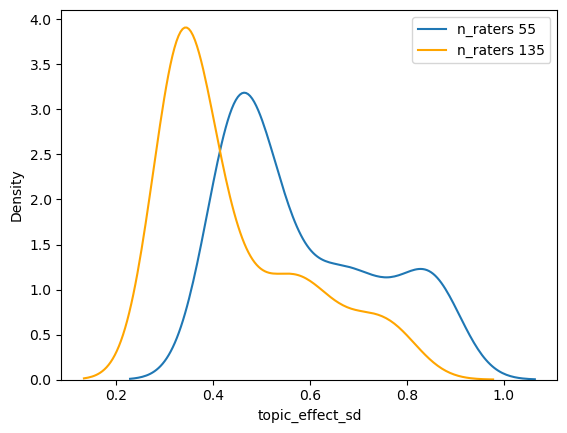

In [115]:
s=summary_statsOA
sigma_a = s[s["param"]=="sigma_a"]
sigma_a=sigma_a.rename(columns={"mean":"sigma_a"})[["n_raters", "sigma_a"]]
s = pd.merge(s, sigma_a, on="n_raters", how="left")
s0=s[(s["param"]=="za")]
s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]

sns.kdeplot(s0[s0["n_raters"]==55]["topic_effect_sd"], label="n_raters 55")
sns.kdeplot(s0[s0["n_raters"]==135]["topic_effect_sd"], c="orange", label="n_raters 135")
plt.legend()
plt.show()

/tmp/ipykernel_56891/1454429574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]


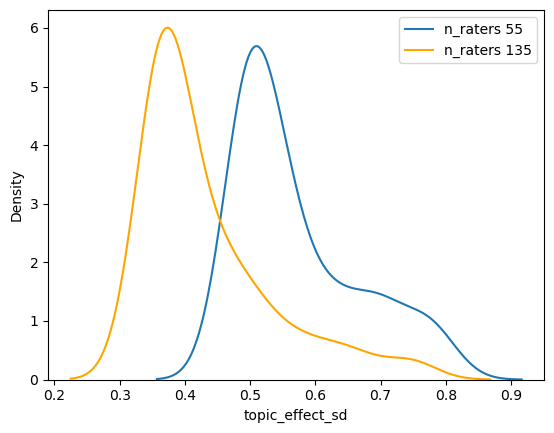

In [116]:
s=summary_stats
sigma_a = s[s["param"]=="sigma_a"]
sigma_a=sigma_a.rename(columns={"mean":"sigma_a"})[["n_raters", "sigma_a"]]
s = pd.merge(s, sigma_a, on="n_raters", how="left")
s0=s[(s["param"]=="za")]
s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]

sns.kdeplot(s0[s0["n_raters"]==55]["topic_effect_sd"], label="n_raters 55")
sns.kdeplot(s0[s0["n_raters"]==135]["topic_effect_sd"], c="orange", label="n_raters 135")
plt.legend()
plt.show()

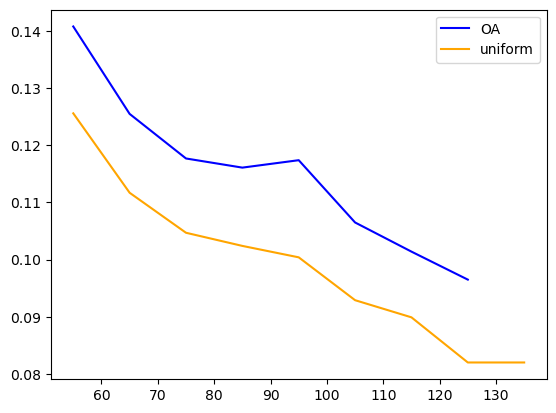

In [108]:
s = summary_statsOA
# param = "mu"
# param_num = "0"
param = "c_diff"
param_num = None
stat = "sd"

if param_num==None:
    s0 = s[(s["param"]==param)]
else:
    s0 = s[(s["param"]==param)&(s["param_num"]==param_num)]

plt.plot(s0["n_raters"], s0[stat], c="blue", label="OA")


s = summary_stats

if param_num==None:
    s0 = s[(s["param"]==param)]
else:
    s0 = s[(s["param"]==param)&(s["param_num"]==param_num)]

plt.plot(s0["n_raters"], s0[stat], c="orange", label="uniform")
plt.legend()
plt.show()